In [32]:
import numpy as np
import xc_limits as xcl

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use("paper.mplstyle")

import os

import dicts
sd_limits = dicts.sd_limit_dict
sd_anns   = dicts.sd_ann_rate_dict # annihilation rate for xs=1pb

In [3]:
dataPath = "/data/user/jlazar/solar_WIMP/data/"

highExp       = 6.5
lowExp        = 0.5
gammaBins     = np.linspace(0, 180, 361) # 113 picked to best match binning on MEOWS wiki page

In [4]:
# def combineHists(ch, m):
#     shape        = np.load("/Users/jlazar/Downloads/ch%d_m%d_nuBar_0_energy_delta_theta_hist_course.npy" % (ch,m)).shape
#     print(shape)
#     nEventsNu    = np.zeros(shape)
#     nEventsNuBar = np.zeros(shape)
#     for i in range(100):
#         nEventsNu    += np.load("/Users/jlazar/Downloads/ch%d_m%d_nu_%d_energy_delta_theta_hist_course.npy" % (ch,m,i))
#         nEventsNuBar += np.load("/Users/jlazar/Downloads/ch%d_m%d_nuBar_%d_energy_delta_theta_hist_course.npy" % (ch,m,i))
    
#     np.save("/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_course/ch%d_m%d_qr_nu_tot_energy_delta_theta_hist_course.npy" % (ch,m), nEventsNu)
#     np.save("/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_course/ch%d_m%d_qr_nuBar_tot_energy_delta_theta_hist_course.npy" % (ch,m), nEventsNuBar)    
#     np.save("/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_course/ch%d_m%d_qr_tot_energy_delta_theta_hist_course.npy" % (ch,m), nEventsNu+nEventsNuBar)    

In [5]:
# def combineSignalHists(ch, mChi, histType=["delta_theta", "energy_delta_theta", "energy_delta_theta_course"]):
#     if histType=="delta_theta":
#         fileStr  = "delta_theta.npy"
#         numFiles = 10
#     elif histType=="energy_delta_theta_course":
#         fileStr  = "energy_delta_theta_hist_course.npy"
#         numFiles = 100
#     else:
#         fileStr  = "energy_delta_theta_hist.npy"
#         numFiles = 100
        
#     print(fileStr)
#     nEventsNu    = np.zeros(np.load("/Users/jlazar/Downloads/ch%d_m%d_nu_0_%s" % (dataPath, ch, mChi, fileStr)).shape)
#     nEventsNuBar = np.zeros(np.load("%s/ch%d_m%d_nu_0_%s" % (dataPath, ch, mChi, fileStr)).shape)
    
    
#     for i in range(numFiles):
#         nEventsNu    += np.load("/Users/jlazar/Downloads/ch%d_m%d_nu_%d_%s" % (dataPath, ch, mChi, i, fileStr))
#         nEventsNuBar += np.load("/Users/jlazar/Downloads/ch%d_m%d_nuBar_%d_%s" % (dataPath, ch, mChi, i, fileStr))
#     return nEventsNu, nEventsNuBar

In [6]:
def combineBGHists(pType=["kaon", "pion"], histType=["delta_theta", "energy_delta_theta", "energy_delta_theta_course"]):
    if histType=="delta_theta":
        fileStr = "delta_theta.npy"
    else:
        fileStr = "energy_delta_theta_hist_bg.npy"
        
    nEventsNu    = np.zeros(np.load("%s/%s_0_%s" % (dataPath, pType, fileStr)).shape)
    nEventsNuBar = nEventsNu
    
    for i in range(10):
        nEventsNu    += np.load("%s/%s_%d_%s" % (dataPath, pType, i, fileStr))
        nEventsNuBar += np.load("%s/%s_bar_%d_%s" % (dataPath, pType, i, fileStr))
    return nEventsNu, nEventsNuBar

In [7]:
def isNonInf(x):
    return ~np.isinf(x)

In [8]:
def trim2DArray(arr, condition=isNonInf):
    minI1, maxI1 = (min(np.where(condition(arr))[0]),max(np.where(condition(arr))[0]))
    minI2, maxI2 = (min(np.where(condition(arr))[1]),max(np.where(condition(arr))[1]))
    newArr       = arr[minI1:maxI1, minI2:maxI2]
    return newArr, minI1, maxI1, minI2, maxI2

In [9]:
def makeHeatMapLabelStr(ch, mChi):
    
    if ch==5 and mChi==500:
        s = r"$b\bar{b}$, $m_{\chi}=500$ GeV"
    elif ch==5 and mChi==1000:
        s = r"$b\bar{b}$, $m_{\chi}=1000$ GeV"
    elif ch==8 and mChi==500:
        s = r"$W^{+}W^{-}$, $m_{\chi}=500$ GeV"
    elif ch==8 and mChi==1000:
        s = r"$W^{+}W^{-}$, $m_{\chi}=1000$ GeV"
    elif ch==11 and mChi==500:
        s = r"$\tau^{+}\tau^{-}$, $m_{\chi}=500$ GeV"
    elif ch==11 and mChi==1000:
        s = r"$\tau^{+}\tau^{-}$, $m_{\chi}=1000$ GeV"
    else:
        s = None
    return s

In [10]:
def makePlotTitleStr(ch):
    if ch==5:
        s = r"Expected number of signal events vs. background, $b\bar{b}$"
    elif ch==8:
        s = "Expected number of signal events vs. background, $W^{+}W^{-}$"
    elif ch==11:
        s = r"Expected number of signal events vs. background, $\tau^{+}\tau^{-}$"
    else:
        s = None
    return s

In [11]:
def makeTicks(arr):
    arr = arr[~np.isinf(arr)]
    a = np.ceil(np.min(arr))
    b = np.floor(np.max(arr))
    c = np.max(arr)
    ticks = []
    # Make sure top two ticks are not too close together
    if c - np.floor(c) < 0.2:
        for i in np.linspace(a,b-1,b-a):
            ticks.append(int(i))
    else:
        for i in np.linspace(a,b,b-a+1):
            ticks.append(int(i))
    ticks.append(c)
    return ticks

In [12]:
def tickFmt(x,pos):
    if int(x)==x:
        return str(int(x))
    else:
        return str(round(x,3))

In [13]:
def round_sig_figs(x, sig_figs=2):
    return round(x, sig_figs-int(np.floor(np.log10(abs(x))))-1)

In [14]:
class Signal():
    
    def __init__(self, ch, mChi):
        
        self.ch   = ch
        self.mChi = mChi
        
        #self.eDThetaFineNu      = np.load("/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_fine/ch%d_m%d_nu_tot_energy_delta_theta_hist.npy" % (ch,mChi))
        #self.eDThetaFineNuBar   = np.load("/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_fine/ch%d_m%d_nuBar_tot_energy_delta_theta_hist.npy" % (ch,mChi))
        #self.eDThetaCourseNu    = np.load("/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_course/ch%d_m%d_nu_tot_energy_delta_theta_hist.npy" % (ch,mChi))
        #self.eDThetaCourseNuBar = np.load("/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_course/ch%d_m%d_nuBar_tot_energy_delta_theta_hist.npy" % (ch,mChi))
        #self.eCourse            = np.load("/Users/jlazar/Documents/IceCube/data/energy_hist/ch%d_m%d_energy_hist_course.npy" % (ch, mChi))
        #self.dTheta             = np.load("/Users/jlazar/Documents/IceCube/data/delta_theta/ch%d_m%d_tot_delta_theta.npy" % (ch, mChi))
        self.eDThetaQrNu        = np.load("/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_course/ch%d_m%d_qr_nu_tot_energy_delta_theta_hist_course.npy" % (ch,mChi))
        self.eDThetaQrNuBar     = np.load("/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_course/ch%d_m%d_qr_nuBar_tot_energy_delta_theta_hist_course.npy" % (ch,mChi))

        #self.eDThetaFineTot   = self.eDThetaFineNu   + self.eDThetaFineNuBar
        #self.eDThetaCourseTot = self.eDThetaCourseNu + self.eDThetaCourseNuBar
        self.eDThetaQrTot     = self.eDThetaQrNu + self.eDThetaQrNuBar

In [15]:
class Background():
    
    def __init__(self,):
        
#         self.eDThetaFineKaon      = np.load("%s/e_d_theta/partial_hists/energy_delta_theta_hist_fine/kaon_tot_energy_delta_theta_hist_bg.npy" % dataPath)
#         self.eDThetaFineKaonBar   = np.load("%s/e_d_theta/partial_hists/energy_delta_theta_hist_fine/kaon_bar_tot_energy_delta_theta_hist_bg.npy" % dataPath)
#         self.eDThetaFinePion      = np.load("%s/e_d_theta/partial_hists/energy_delta_theta_hist_fine/pion_tot_energy_delta_theta_hist_bg.npy" % dataPath)
#         self.eDThetaFinePionBar   = np.load("%s/e_d_theta/partial_hists/energy_delta_theta_hist_fine/pion_bar_tot_energy_delta_theta_hist_bg.npy" % dataPath)
        
        self.eDThetaCourseKaon    = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/kaon_tot_energy_delta_theta_hist_bg.npy")
        self.eDThetaCourseKaonBar = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/kaon_bar_tot_energy_delta_theta_hist_bg.npy")
        self.eDThetaCoursePion    = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/pion_tot_energy_delta_theta_hist_bg.npy")
        self.eDThetaCoursePionBar = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/pion_bar_tot_energy_delta_theta_hist_bg.npy")
        
#         self.eDThetaFineTot   = self.eDThetaFineKaon + self.eDThetaFineKaonBar + self.eDThetaFinePion + self.eDThetaFinePionBar
        self.eDThetaCourseTot = self.eDThetaCourseKaon + self.eDThetaCourseKaonBar + self.eDThetaCoursePion + self.eDThetaCoursePionBar

In [16]:
def makePlot(ch, bigFont=False):
    
    if bigFont:
        fontsize=30
    else:
        fontsize=18
    
    leftThetaEdges = np.linspace(0,179,360)
    
    signal500  = Signal(ch, 500)
    signal1000 = Signal(ch, 1000)

    totBg = kaonBG.dThetaTot+pionBG.dThetaTot

    fig = plt.figure(figsize=(16, 16))
    gs = gridspec.GridSpec (3, 1, height_ratios=[4,1,1])
    xlim = (0,8)

    ax0 = fig.add_subplot(gs[0])

    ax0.step(leftThetaEdges, signal500.dThetaTot, label=r"$m_{\chi}=500$ GeV")
    ax0.step(leftThetaEdges, signal1000.dThetaTot, label=r"$m_{\chi}=1000$ GeV")
    # ax0.step(leftEdges, kaonBG.dThetaTot, label="kaon background")
    # ax0.step(leftEdges, pionBG.dThetaTot, label="pion background")
    ax0.step(leftThetaEdges, totBg, label="Background")

    ax0.set_ylabel(r"$N_{events}$", fontsize=fontsize,)
    ax0.set_xlim(xlim)
    ax0.legend(loc='lower left', framealpha=0.75, fontsize=26)
    ax0.set_yscale('log')
    ax0.set_title(makePlotTitleStr(ch), fontsize=fontsize,)
    ax0.grid()
    ax0.tick_params(labelsize=22)


    #first ration plot
    ax1 = fig.add_subplot (gs[1])
    ratio = np.divide(signal500.dThetaTot, totBg, out=signal500.dThetaTot, where=totBg!=0)
    ax1.step(leftThetaEdges, ratio, label=r"$m_{\chi}=500$ GeV")

    plt.legend(loc="upper right", framealpha=0.75, fontsize=30)
    ax1.set_xlim(xlim)
    ax1.set_yscale('log')
    ax1.set_ylabel(r'signal / background',fontsize=18)
    ax1.grid()
    ax1.tick_params(labelsize=22)

    # Second ratio plot
    ax2 = fig.add_subplot (gs[2])

    ratio = np.divide(signal1000.dThetaTot, totBg, out=signal1000.dThetaTot, where=totBg!=0)
    ax2.step(leftThetaEdges, ratio, label=r"$m_{\chi}=1000$ GeV")

    plt.legend(loc="upper right", framealpha=0.75, fontsize=20)
    ax2.set_xlim(xlim)
    ax2.grid()
    ax2.set_yscale('log')
    ax2.set_ylabel(r'signal / background', fontsize=18,)
    ax2.set_xlabel(r"$\Delta\theta$", fontsize=fontsize,)
    ax2.tick_params(labelsize=22)


    plt.show()

In [20]:
# def makeRatioHeatMap(ch, mChi, binning=["fine", "course"], save=False, bigFont=False, show=True):

    
#     if bigFont:
#         fontsize    = 38
#         tickLabSize = 38
#     else:
#         fontsize    = 18
#         tickLabSize = 18
        
#     if binning=="fine":
#         signal = Signal(ch, mChi).eDThetaFineTot
#         totBG   = Background().eDThetaFineTot
#         eBins   = np.logspace(lowExp, highExp, int( 71* (highExp-lowExp) + 1)) # 71 picked to best match binning on MEOWS wiki page
#         saveDir = "/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_fine"
#     else:
#         signal = Signal(ch, mChi).eDThetaCourseTot
#         totBG   = Background().eDThetaCourseTot
#         eBins   = np.logspace(lowExp, highExp, int(10 * (highExp-lowExp) + 1))
#         saveDir = "/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_course"
    
#     labelStr    = makeHeatMapLabelStr(ch, mChi)
    
    
#     logRatio        = np.where(~np.isnan(np.log10(np.divide(signal,totBG))), np.log10(np.divide(signal,totBG)), -np.inf)
#     newLogRatio, minThetaI, maxThetaI, minEnI, maxEnI = trim2DArray(logRatio)
#     newLogRatio     = newLogRatio.T[::-1]
    
#     fig = plt.figure(figsize=(10,10))

#     ax = fig.add_subplot(111)
#     im = plt.imshow(newLogRatio, interpolation='none', extent=[gammaBins[minThetaI], gammaBins[maxThetaI], np.log10(eBins[minEnI]), np.log10(eBins[maxEnI])], aspect="auto")

# #     ax.set_title(r'Signal to background ratio')
#     ax.set_xlabel(r"$\Delta\theta_{\rm{reco}}$ (Degrees)", fontsize=fontsize)
#     ax.set_ylabel(r"$\log_{10}\left(E_{\rm{reco}}/\rm{GeV}\right)$", fontsize=fontsize)
#     ax.tick_params(labelsize=tickLabSize)
#     ax.grid(b=False)

#     at = AnchoredText(labelStr, prop=dict(size=30), 
#                                 frameon=True,
#                                 loc='lower right')
#     at.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
#     ax.add_artist(at)
    
# #     ax.text(14, 3.5, "IceCube Preliminary", color="red", fontsize=30)
        
#     divider = make_axes_locatable(ax)
#     cax     = divider.append_axes("right", size="5%", pad=0.05)
#     cbar    = plt.colorbar(im, cax=cax, ticks=makeTicks(newLogRatio), format=ticker.FuncFormatter(tickFmt))
#     cbar.ax.tick_params(labelsize=tickLabSize)
#     cbar.set_label(r"$\log_{10}\left(N_{\rm{Signal}} / N_{\rm{Background}}\right)$", fontsize=fontsize, labelpad=10)

#     if save and bigFont:
#         plt.savefig("%s/ch%d_m%d_snr_heatmap_large_font.png" % (saveDir, ch, mChi))
#     elif save and ~bigFont:
#         plt.savefig("%s/ch%d_m%d_snr_heatmap.png" % (saveDir, ch, mChi))
    
#     if show:
#         plt.show()

In [21]:
# def makeSignalHeatMap(ch, mChi, binning=["fine", "course"], flux=["ws", "qr"], save=False, bigFont=False, show=True,):
    
        
#     if bigFont:
#         fontsize    = 38
#         tickLabSize = 38
#     else:
#         fontsize    = 18
#         tickLabSize = 18

#     labelStr    = makeHeatMapLabelStr(ch, mChi)
    
#     if binning=="fine":
#         eBins   = np.logspace(lowExp, highExp, int( 71* (highExp-lowExp) + 1)) # 71 picked to best match binning on MEOWS wiki page
#         saveDir = "/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_fine"
#         if flux=="ws":
#             signal  = Signal(ch, mChi).eDThetaFineTot
#         else:
#             raise Exception("Qinrui's flux only for course binning")
#     else:
#         eBins   = np.logspace(lowExp, highExp, int(10 * (highExp-lowExp) + 1))
#         saveDir = "/Users/jlazar/Documents/IceCube/data/energy_delta_theta_hist_course"
#         if flux=="ws":
#             signal = Signal(ch, mChi).eDThetaCourseTot
#         else:
#             signal = Signal(ch, mChi).eDThetaQrTot
        
#     logSignal       = np.log10(signal)
#     newLogSignal, minThetaI, maxThetaI, minEnI, maxEnI = trim2DArray(logSignal)
#     newLogSignal = newLogSignal.T[::-1]
    
#     fig = plt.figure(figsize=(10,10))

#     ax = fig.add_subplot(111)
#     im = plt.imshow(newLogSignal, interpolation='none', extent=[gammaBins[minThetaI], gammaBins[maxThetaI], np.log10(eBins[minEnI]), np.log10(eBins[maxEnI])], aspect="auto")

# #     ax.set_title(r'Signal to background ratio')
#     ax.set_xlabel(r"$\Delta\theta_{\rm{reco}}$ (Degrees)", fontsize=fontsize)
#     ax.set_ylabel(r"$\log_{10}\left(E_{\rm{reco}}/\rm{GeV}\right)$", fontsize=fontsize)
#     ax.tick_params(labelsize=tickLabSize)
#     ax.grid(b=False)

#     at = AnchoredText(labelStr, prop=dict(size=30), 
#                                 frameon=True,
#                                 loc='lower right')
#     at.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
#     ax.add_artist(at)
    
# #     ax.text(14, 3.5, "IceCube Preliminary", color="red", fontsize=30)
        
#     divider = make_axes_locatable(ax)
#     cax     = divider.append_axes("right", size="5%", pad=0.05)
#     #cbar    = plt.colorbar(im, cax=cax, ticks=makeTicks(newLogSignal), )#format=ticker.FuncFormatter(tickFmt))
#     #cbar.ax.tick_params(labelsize=tickLabSize)
#     #cbar.set_label(r"$\log_{10}\left(N_{\rm{Signal}}\right)$", fontsize=fontsize, labelpad=10)

#     if save and bigFont:
#         plt.savefig("%s/ch%d_m%d_signal_heatmap_large_font.png" % (saveDir, ch, mChi))
#     elif save and ~bigFont:
#         plt.savefig("%s/ch%d_m%d_signal_heatmap.png" % (saveDir, ch, mChi))
    
#     if show:
#         plt.show()

In [17]:
def signal_heatmap(ch, m, trim_i=25, show=True, save=False, l_e_min=1, l_e_max=4):
    
    log_e_edges = np.linspace(6.5, 0.5, 61)
    min_e_i     = np.where(log_e_edges==l_e_min)[0][0]
    max_e_i     = np.where(log_e_edges==l_e_max)[0][0]
    
    log_signal      = np.log10(np.load("/Users/jlazar/Documents/IceCube/data/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch, m)))
    log_signal_trim = log_signal[max_e_i:min_e_i,:trim_i] # Get rid of areas of plot that are empty space
    n_tot           = np.sum(np.power(10, log_signal))
    
    fontsize = 32
    
    fig, ax = plt.subplots(1, 1, figsize=[10, 10])

    im = ax.imshow(log_signal_trim, 
                   interpolation='none', 
                   aspect="auto", 
                   extent=[0, 40.2, l_e_min, l_e_max],
                  )


    ax.set_xlabel(r"$\Delta\theta_{\rm{reco}}$ (Degrees)", fontsize=fontsize)
    ax.set_ylabel(r"$\log_{10}\left(E_{\rm{reco}}/\rm{GeV}\right)$", fontsize=fontsize)

    if ch==5:
        at_str = r"$b\bar{b}$, $m_{\chi}=%d$ GeV" % m
    elif ch==8:
        at_str = r"$W^{+}W^{-}$, $m_{\chi}=%d$ GeV" % m
    elif ch==11:
        at_str = r"$\tau^{+}\tau^{-}$, $m_{\chi}=%d$ GeV" % m
    else:
        print("Channel must be in [5,8,11]")
    
    # Add channel label
    at1 = AnchoredText(at_str, 
                       prop=dict(size=30), 
                       frameon=True,
                       loc='lower right')
    at1.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
    ax.add_artist(at1)
    
    # Add total number of events label
    at2 = AnchoredText(r"$N_{tot}$=%s" % str(round_sig_figs(n_tot, sig_figs=4)), 
                       prop=dict(size=30), 
                       frameon=True,
                       loc='lower left')
    at2.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
    ax.add_artist(at2)
    

    # Set up color bar
    axins = inset_axes(ax,
                       width="5%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 100%
                       loc='lower left',
                       bbox_to_anchor=(1.05, 0., 1, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0,
                       )

    cbar = fig.colorbar(im, cax=axins, ticks=makeTicks(log_signal_trim), format=ticker.FuncFormatter(tickFmt))
    cbar.set_label(r"$\log_{10}\left(N_{\rm{Signal}}\right)$", fontsize=fontsize, labelpad=10)
    
    if save:
        plt.savefig("/Users/jlazar/Documents/IceCube/data/ch%d_m%d_signal_heatmap.png" % (ch, m))
    if show:
        plt.show()

In [25]:
makeSignalHeatMap(8, 5000, binning="course", flux="qr")

SyntaxError: invalid syntax (<ipython-input-25-2b6ffdf2df94>, line 1)

In [19]:
def makeBackgroundHeatMap(binning=["fine", "course"], save=False, bigFont=False, show=True, eClipIs=()):
    
    if bigFont:
        fontsize    = 38
        tickLabSize = 38
    else:
        fontsize    = 18
        tickLabSize = 18
        
    if binning=="fine":
        eI1     = 57
        eI2     = 227
        totBG   = Background().eDThetaFineTot[:24,eI1:eI2]
        eBins   = np.logspace(lowExp, highExp, int( 71* (highExp-lowExp) + 1)) # 71 picked to best match binning on MEOWS wiki page
        saveDir = "/Users/jlazar/Documents/IceCube/data/e_d_theta/energy_delta_theta_hist_fine"
    else:
        eI1     = 8
        eI2     = 32
        totBG   = Background().eDThetaCourseTot[:24,eI1:eI2]
        eBins   = np.logspace(lowExp, highExp, int(10 * (highExp-lowExp) + 1))
        saveDir = "/Users/jlazar/Documents/IceCube/data/e_d_theta/energy_delta_theta_hist_course"
    
#     labelStr    = makeHeatMapLabelStr(ch, mChi)

#     newLogBg, minThetaI, maxThetaI, minEnI, maxEnI = trim2DArray(np.log10(totBG))
#     newLogBg = newLogBg.T[::-1]
    newLogBg = np.log10(totBG).T[::-1]
    
    fig = plt.figure(figsize=(10,10))

    
    ax = fig.add_subplot(111)
    im = plt.imshow(newLogBg, interpolation='none', extent=[gammaBins[0], gammaBins[24], np.log10(eBins[eI1]), np.log10(eBins[eI2])], aspect="auto")
    

#     ax.set_title(r'Signal to background ratio')
    ax.set_xlabel(r"$\Delta\theta_{\rm{reco}}$ (Degrees)", fontsize=fontsize)
    ax.set_ylabel(r"$\log_{10}\left(E_{\rm{reco}}/\rm{GeV}\right)$", fontsize=fontsize)
    ax.tick_params(labelsize=tickLabSize)
    ax.grid(b=False)

#     at = AnchoredText(labelStr, prop=dict(size=20), 
#                                 frameon=True,
#                                 loc='upper right')
#     at.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
#     ax.add_artist(at)
        
    divider = make_axes_locatable(ax)
    cax     = divider.append_axes("right", size="5%", pad=0.05)
    cbar    = plt.colorbar(im, cax=cax, ticks=makeTicks(newLogBg), format=ticker.FuncFormatter(tickFmt))
    cbar.ax.tick_params(labelsize=tickLabSize)
    cbar.set_label(r"$\log_{10}\left(N_{\rm{Background}}\right)$", fontsize=fontsize, labelpad=10)
    
#     ax.text(14, 3.5, "IceCube Preliminary", color="red", fontsize=30)

    if save and bigFont:
        plt.savefig("%s/background_heatmap_large_font.png" % (saveDir))
    elif save and ~bigFont:
        plt.savefig("%s/background_heatmap.png" % (saveDir))
    
    if show:
        plt.show()

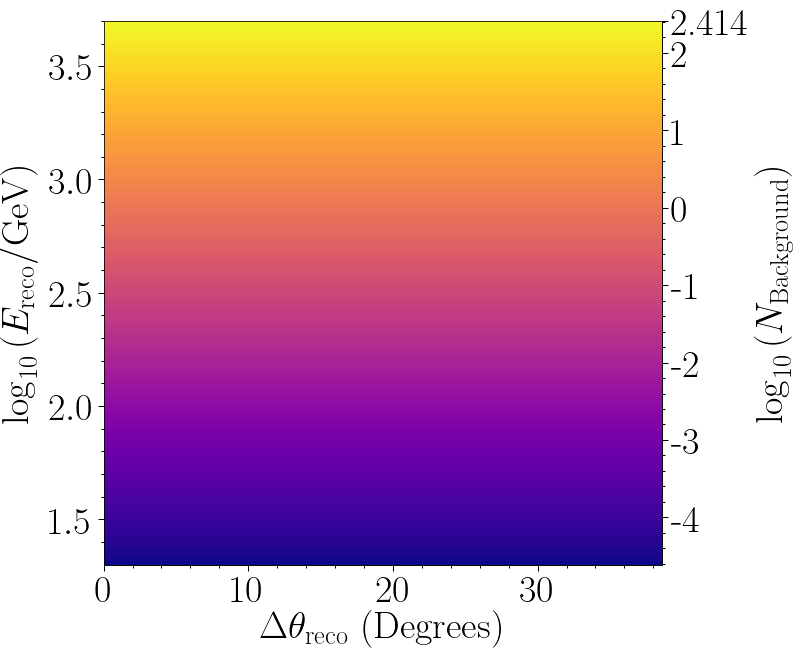

In [56]:
makeBackgroundHeatMap("course", bigFont=True, save=False)

In [18]:
chs = [5,8,11]
ms  = [500, 1000,3000,5000,10000]
_   = ["course", "fine"]
for blah in _:
#     makeBackgroundHeatMap(blah, save=True, bigFont=True)
    for m in ms:
        for ch in chs:
#             makeRatioHeatMap(ch, m, blah, save=True, bigFont=True)
            makeSignalHeatMap(ch, m, blah, save=True, bigFont=True)

NameError: name 'makeSignalHeatMap' is not defined

## This makes that plot ##

In [7]:
chs = [5,8,11]
mChis = [500,1000, 5000, 10000]
bigFonts = [True,False]

# for ch in chs:
#     for mChi in mChis:
#         for bigFont in bigFonts:
#             makeRatioHeatMap(ch,mChi=mChi,bigFont=bigFont,save=True)

makeRatioHeatMap(8,1000, bigFont=True)



NameError: name 'makeRatioHeatMap' is not defined

In [ ]:
makeSignalHeatMap(5, 500, "fine",save=True, bigFont=True)

In [19]:
ww1000 = Signal(8, 1000)
ww500  = Signal(8, 500)

In [20]:
bb500  = Signal(5,500)
bb1000 = Signal(5,1000)
ww500  = Signal(8,500)
ww1000 = Signal(8,1000)
tt500  = Signal(11,500)
tt1000 = Signal(11,1000)

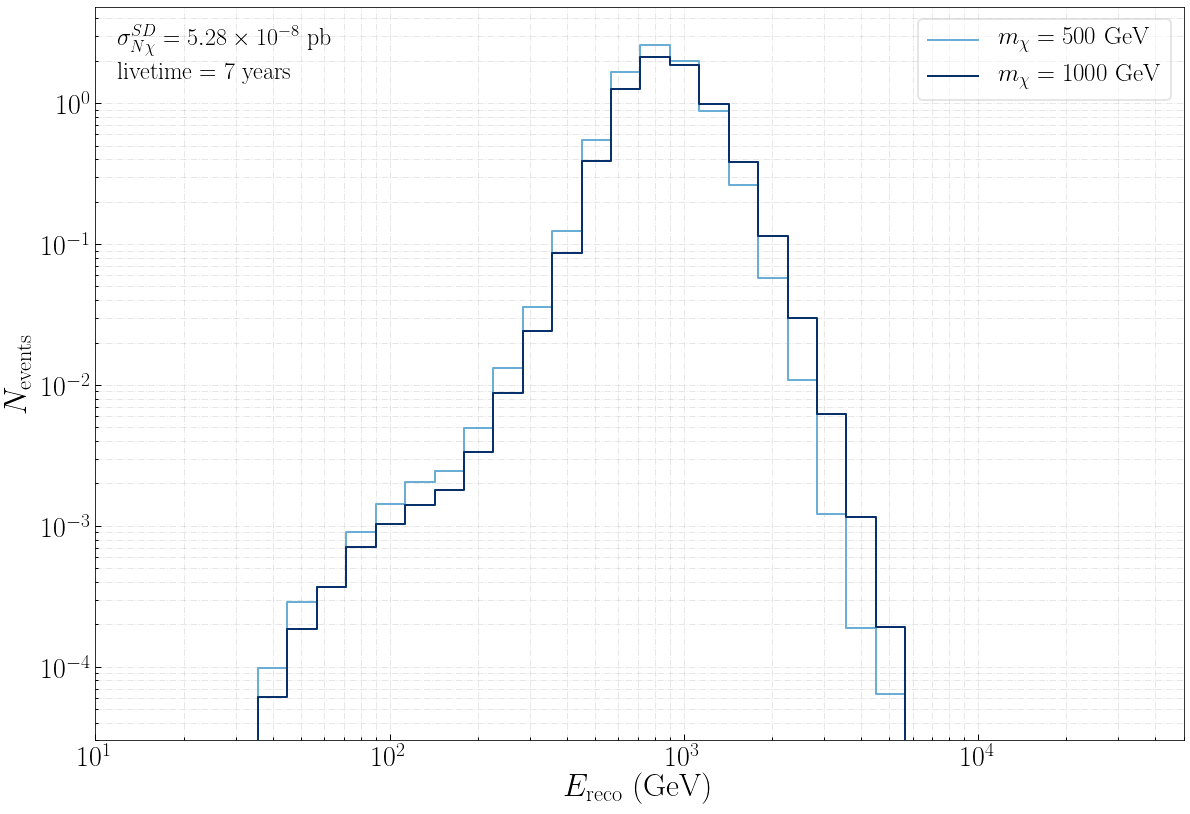

In [21]:
binsPerDecade = 10
highExp       = 6.5
lowExp        = 0.5
eBins         = np.logspace(lowExp, highExp, int(binsPerDecade * (highExp-lowExp) + 1))

numLines  = 3
cmap      = plt.get_cmap('Blues')
cNorm     = colors.Normalize(vmin=0, vmax=numLines-1)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)

xcLims = xcl.Limits(8)

fig = plt.figure(figsize=(19.5,13.5))

ax  = fig.add_subplot(111)
ax.step(eBins[1:], ww500.eCourse,  color=scalarMap.to_rgba(1), label=r"$m_{\chi}=500$ \rm{GeV}", where="mid")
ax.step(eBins[1:], ww1000.eCourse, color=scalarMap.to_rgba(2), label=r"$m_{\chi}=1000$ \rm{GeV}", where="mid")
# plt.plot(centers, bgHist[0], label=r"Background", color="slategrey", 
#          linestyle="--", drawstyle="steps", lw=2)


at = AnchoredText("$ \\sigma_{N \\chi}^{SD}=5.28 \\times 10^{-8}$ pb \n livetime~=~7 years", prop=dict(size=24), 
                            frameon=False,
                            loc='upper left')
at.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
ax.add_artist(at)

ax.loglog()
ax.set_xlim(10,5e4)
ax.set_ylim(bottom=3.e-5)
ax.legend(loc="best", framealpha=0.5, fontsize=25)
ax.grid(linewidth=1, which = 'both', alpha = 0.3,ls='-.')
ax.set_xlabel(r"$E_{\rm{reco}}$ (GeV)", fontsize=32)
ax.set_ylabel(r"$N_{\rm{events}}$", fontsize=32)
ax.tick_params(which="both", labelsize=28, direction="in")

# plt.savefig("/Users/jlazar/Documents/IceCube/data/ch5_exp_num_events.png")
# plt.savefig("/Users/jlazar/Documents/IceCube/data/ch5_exp_num_events_no_bg.png")
plt.savefig("data/plots/gooder_plot.pdf",dpi=600,bbox_inches='tight')
plt.show()

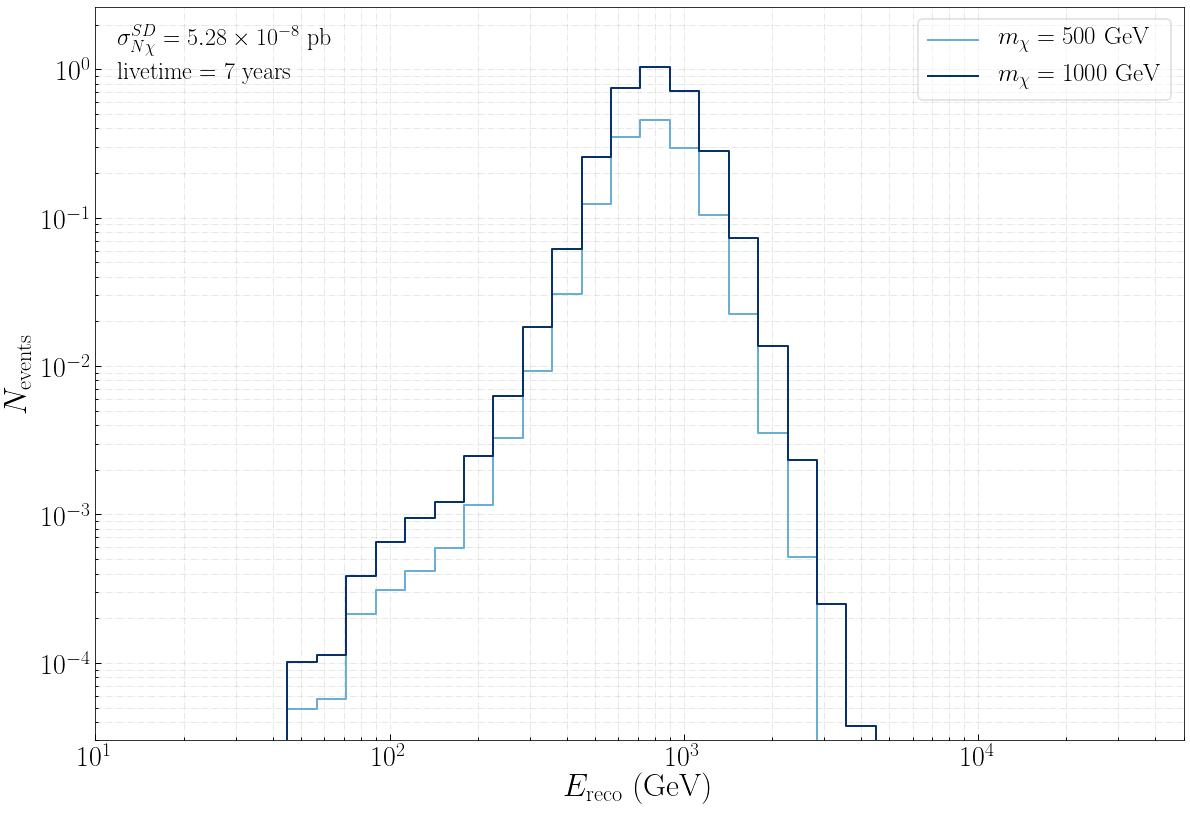

In [22]:
binsPerDecade = 10
highExp       = 6.5
lowExp        = 0.5
eBins         = np.logspace(lowExp, highExp, int(binsPerDecade * (highExp-lowExp) + 1))

numLines  = 3
cmap      = plt.get_cmap('Blues')
cNorm     = colors.Normalize(vmin=0, vmax=numLines-1)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)

xcLims = xcl.Limits(8)

fig = plt.figure(figsize=(19.5,13.5))

ax  = fig.add_subplot(111)
ax.step(eBins[1:], bb500.eCourse,  color=scalarMap.to_rgba(1), label=r"$m_{\chi}=500$ \rm{GeV}", where="mid")
ax.step(eBins[1:], bb1000.eCourse, color=scalarMap.to_rgba(2), label=r"$m_{\chi}=1000$ \rm{GeV}", where="mid")
# plt.plot(centers, bgHist[0], label=r"Background", color="slategrey", 
#          linestyle="--", drawstyle="steps", lw=2)


at = AnchoredText("$ \\sigma_{N \\chi}^{SD}=5.28 \\times 10^{-8}$ pb \n livetime~=~7 years", prop=dict(size=24), 
                            frameon=False,
                            loc='upper left')
at.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
ax.add_artist(at)

ax.loglog()
ax.set_xlim(10,5e4)
ax.set_ylim(bottom=3.e-5)
ax.legend(loc="best", framealpha=0.5, fontsize=25)
ax.grid(linewidth=1, which = 'both', alpha = 0.3,ls='-.')
ax.set_xlabel(r"$E_{\rm{reco}}$ (GeV)", fontsize=32)
ax.set_ylabel(r"$N_{\rm{events}}$", fontsize=32)
ax.tick_params(which="both", labelsize=28, direction="in")

# plt.savefig("/Users/jlazar/Documents/IceCube/data/ch5_exp_num_events.png")
# plt.savefig("/Users/jlazar/Documents/IceCube/data/ch5_exp_num_events_no_bg.png")
plt.savefig("data/plots/gooder_plot.pdf",dpi=600,bbox_inches='tight')
plt.show()

In [40]:
def signal_heatmap(ch, m, binning, trim_i=81, show=True, save=False, l_e_min=1, l_e_max=4):
    
    log_e_edges = np.linspace(6.5, 0.5, 61)
    min_e_i     = np.where(log_e_edges==l_e_min)[0][0]
    max_e_i     = np.where(log_e_edges==l_e_max)[0][0]
    print(min_e_i)
    print(max_e_i )
    
    factor      = sd_limits[ch][m] * sd_anns[m] * 1./m * 30 * 60
    
    if binning=="f":
        log_signal = np.log10(factor*np.load("data/e_d_theta_hist/ch%d_m%d_f1.000000_f_tot_e_d_theta_hist.npy" % (ch, m)))
        trim_i     = 81
    elif binning=="c":
        log_signal = np.log10(factor*np.load("data/e_d_theta_hist/ch%d_m%d_f1.000000_c_tot_e_d_theta_hist.npy" % (ch, m)))
        trim_i     = 25
    else:
        print("Invalid binning option. Binning must be 'f' or 'c'")
        quit()
    
    
    log_signal_trim = log_signal[max_e_i:min_e_i,:trim_i] # Get rid of areas of plot that are empty space
    n_tot           = np.sum(np.power(10, log_signal))
    
    fontsize = 32
    
    fig, ax = plt.subplots(1, 1, figsize=[10, 10])

    im = ax.imshow(log_signal_trim, 
                   interpolation='none', 
                   aspect="auto", 
                   extent=[0, 40.2, l_e_min, l_e_max],
                   vmin=-4, vmax=0)


    ax.set_xlabel(r"$\Delta\theta_{\rm{reco}}$ (Degrees)", fontsize=fontsize)
    ax.set_ylabel(r"$\log_{10}\left(E_{\rm{reco}}/\rm{GeV}\right)$", fontsize=fontsize)

    if ch==5:
        desc_str = r"$b\bar{b}$, $m_{\chi}=%d$ GeV" % m
    elif ch==8:
        desc_str = r"$W^{+}W^{-}$, $m_{\chi}=%d$ GeV" % m
    elif ch==11:
        desc_str = r"$\tau^{+}\tau^{-}$, $m_{\chi}=%d$ GeV" % m
    else:
        print("Channel must be in [5,8,11]")
    
    # Add channel label
    at1 = AnchoredText(desc_str, 
                       prop=dict(size=30), 
                       frameon=True,
                       loc='lower right')
    at1.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
    ax.add_artist(at1)
    
    # Add total number of events label
    at2 = AnchoredText(r"$N_{tot}$=%s" % str(round_sig_figs(n_tot, sig_figs=4)), 
                       prop=dict(size=30), 
                       frameon=True,
                       loc='lower left')
    at2.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
    ax.add_artist(at2)
    

    # Set up color bar
    axins = inset_axes(ax,
                       width="5%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 100%
                       loc='lower left',
                       bbox_to_anchor=(1.05, 0., 1, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0,
                       )

    cbar = fig.colorbar(im, cax=axins, ticks=makeTicks(log_signal_trim), format=ticker.FuncFormatter(tickFmt))
    cbar.set_label(r"$\log_{10}\left(N_{\rm{Signal}}\right)$", fontsize=fontsize, labelpad=10)
    
    if save:
        plt.savefig("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_signal_heatmap.png" % (ch, m))
    if show:
        plt.show()
        
    print(n_tot)


In [20]:
# for ch in [11,8,5]:
#     for m in [300, 500, 1000, 3000, 5000, 10000]:
#         h = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch5_m1000_f1.000000_f_nu_0_energy_delta_theta_hist_im_gonna_scream.npy").shape)
#         for i in range(25):
#             h+=np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f1.000000_f_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch,m,i))
#             h+=np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f1.000000_f_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch,m,i))
#         np.save("data/e_d_theta_hist/ch%d_m%d_f1.000000_f_tot_e_d_theta_hist.npy" % (ch,m), h.T[::-1])

(5, 500)
55
18


/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


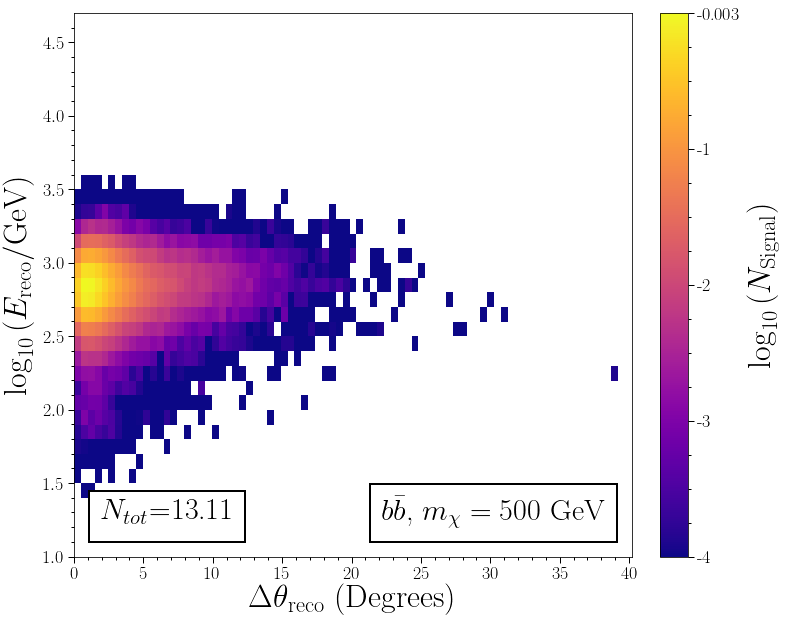

13.106264384379557
(5, 1000)
55
18


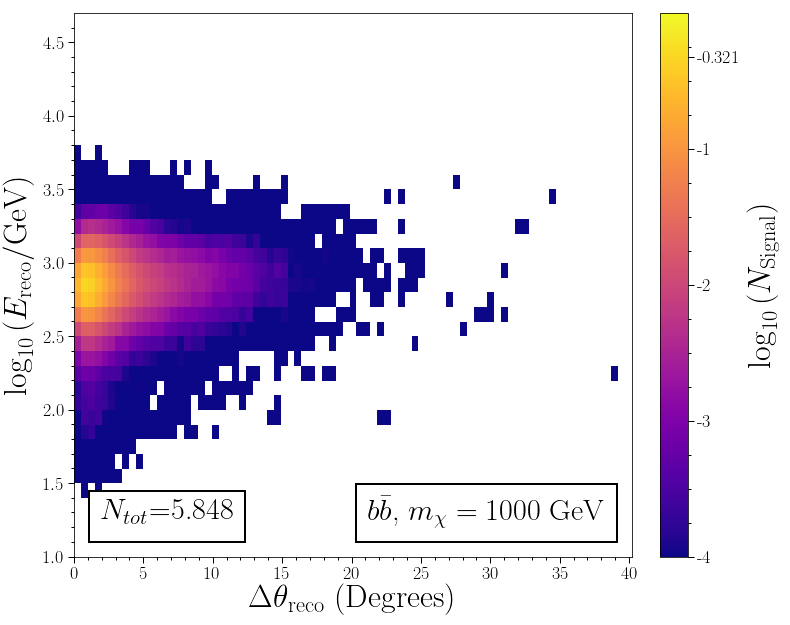

5.847583521447362
(5, 3000)
55
18


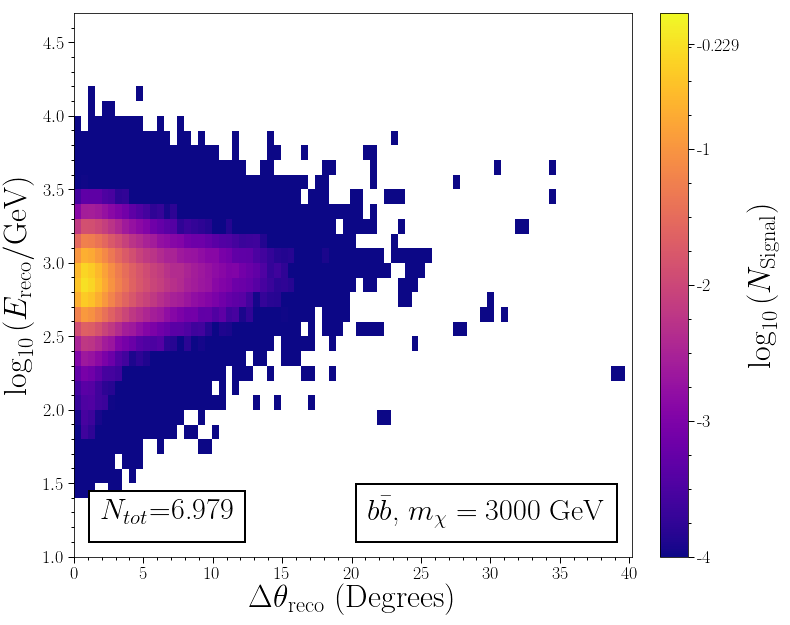

6.97851003221141
(5, 5000)
55
18


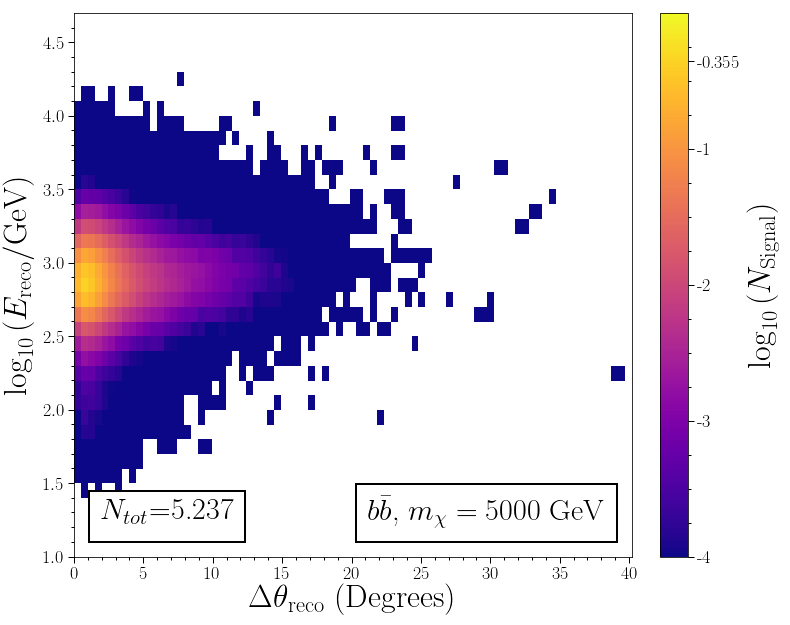

5.237117709572885
(5, 10000)
55
18


IOError: [Errno 2] No such file or directory: 'data/e_d_theta_hist/ch5_m10000_f1.000000_f_tot_e_d_theta_hist.npy'

In [41]:
chs = [5,8,11]
ms  = [500, 1000, 3000, 5000, 10000]

for ch in chs:
    for m in ms:
        print(ch, m)
        signal_heatmap(ch, m, "f", l_e_max=4.7, save=False)

In [37]:
def bg_heatmap(trim_i=81, show=True, save=False, l_e_min=1, l_e_max=4):
    
    log_e_edges = np.linspace(6.5, 0.5, 61)
    min_e_i     = np.where(log_e_edges==l_e_min)[0][0]
    max_e_i     = np.where(log_e_edges==l_e_max)[0][0]
    
#     k_bg = np.load("data/e_d_theta_hist/kaon_tot_energy_delta_theta_hist_bg.npy")
#     kb_bg = np.load("data/e_d_theta_hist/kaon_bar_tot_energy_delta_theta_hist_bg.npy")
#     p_bg = np.load("data/e_d_theta_hist/pion_tot_energy_delta_theta_hist_bg.npy")
#     pb_bg = np.load("data/e_d_theta_hist/pion_bar_tot_energy_delta_theta_hist_bg.npy")
#     tot_bg = k_bg+kb_bg+p_bg+pb_bg
    tot_bg = np.load("data/e_d_theta_hist/bg_tot_e_d_theta_hist.npy")
    
    
    log_signal      = np.log10(tot_bg).T[::-1]
    log_signal_trim = log_signal[max_e_i:min_e_i,:trim_i] # Get rid of areas of plot that are empty space
#     log_signal_trim = log_signal_trim[np.where(log_signal_trim>-3)]
    n_tot           = np.sum(np.power(10, log_signal))
    
    fontsize = 32
    
    fig, ax = plt.subplots(1, 1, figsize=[10, 10])

    im = ax.imshow(log_signal_trim, 
                   interpolation='none', 
                   aspect="auto", 
                   extent=[0, 40.2, l_e_min, l_e_max],
                  )


    ax.set_xlabel(r"$\Delta\theta_{\rm{reco}}$ (Degrees)", fontsize=fontsize)
    ax.set_ylabel(r"$\log_{10}\left(E_{\rm{reco}}/\rm{GeV}\right)$", fontsize=fontsize)

#     if ch==5:
#         desc_str = r"$b\bar{b}$, $m_{\chi}=%d$ GeV" % m
#     elif ch==8:
#         desc_str = r"$W^{+}W^{-}$, $m_{\chi}=%d$ GeV" % m
#     elif ch==11:
#         desc_str = r"$\tau^{+}\tau^{-}$, $m_{\chi}=%d$ GeV" % m
#     else:
#         print("Channel must be in [5,8,11]")
    
    # Add channel label
#     at1 = AnchoredText(desc_str, 
#                        prop=dict(size=30), 
#                        frameon=True,
#                        loc='lower right')
#     at1.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
#     ax.add_artist(at1)
    
    # Add total number of events label
    at2 = AnchoredText(r"$N_{tot}$=%s" % str(round_sig_figs(n_tot, sig_figs=4)), 
                       prop=dict(size=30), 
                       frameon=True,
                       loc='lower left')
    at2.patch.set_boxstyle("round, pad=0.,rounding_size=0.")
    ax.add_artist(at2)
    

    # Set up color bar
    axins = inset_axes(ax,
                       width="5%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 100%
                       loc='lower left',
                       bbox_to_anchor=(1.05, 0., 1, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0,
                       )

    cbar = fig.colorbar(im, cax=axins, ticks=makeTicks(log_signal_trim), format=ticker.FuncFormatter(tickFmt))
    cbar.set_label(r"$\log_{10}\left(N_{\rm{Background}}\right)$", fontsize=fontsize, labelpad=10)
    
    if save:
        plt.savefig("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/bg_heatmap.png" % (ch, m))
    if show:
        plt.show()
        
    print(n_tot)


/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


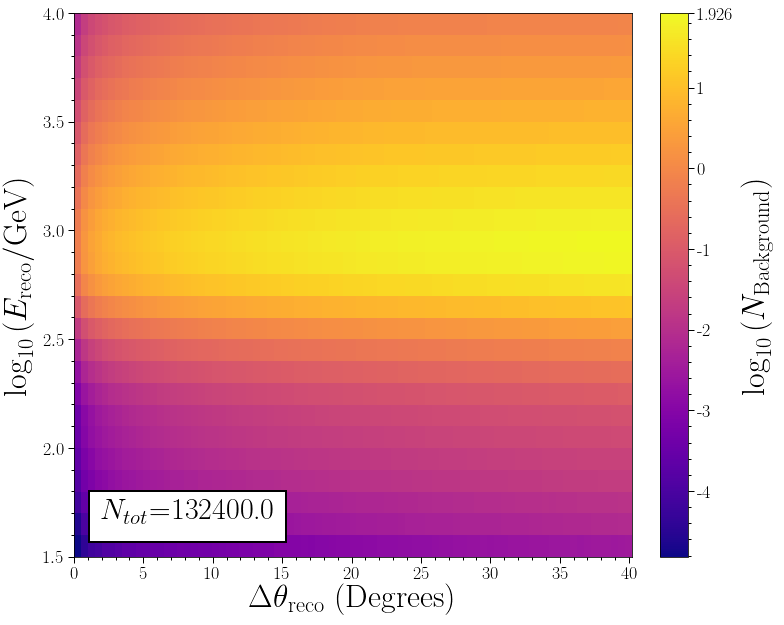

132435.66095861286


In [38]:
bg_heatmap(trim_i=81, show=True, save=False, l_e_min=1.5, l_e_max=4)

60


[]

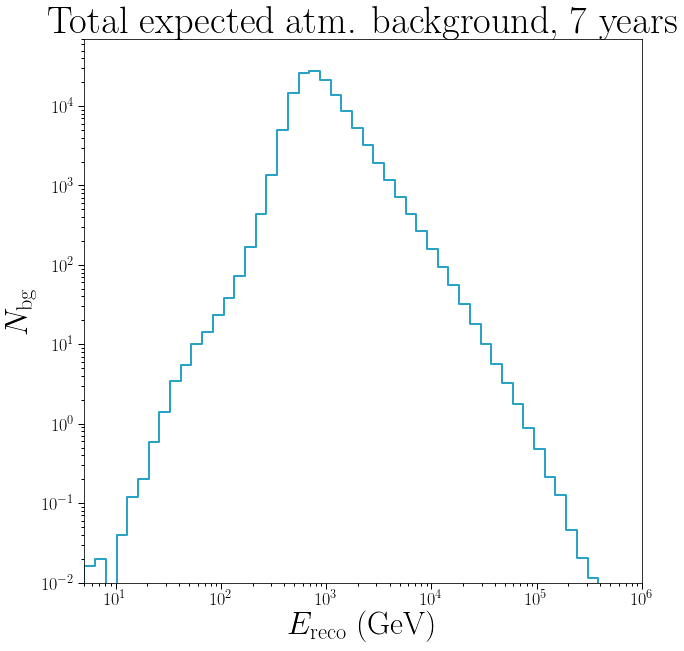

In [39]:
tot_bg = np.load("data/e_d_theta_hist/bg_tot_e_d_theta_hist.npy")
print(len( np.sum(tot_bg, axis=0)))
plt.step(np.logspace(0.5,6.5,60), np.sum(tot_bg, axis=0))

plt.title("Total expected atm. background, 7 years")
plt.xlabel(r"$E_{\rm{reco}}$ (GeV)")
plt.ylabel(r"$N_{\rm{bg}}$")

plt.ylim(1e-2, 7e4)
plt.xlim(5, 1e6)
plt.loglog()


In [31]:
h = np.zeros(np.load("data/e_d_theta_hist/partial_hists/kaon_f_0_energy_delta_theta_hist_bg.npy").shape)
for i in range(10):
    h += np.load("data/e_d_theta_hist/partial_hists/kaon_f_%d_energy_delta_theta_hist_bg.npy" % i)
    h += np.load("data/e_d_theta_hist/partial_hists/pion_f_%d_energy_delta_theta_hist_bg.npy" % i)
    h += np.load("data/e_d_theta_hist/partial_hists/kaon_bar_f_%d_energy_delta_theta_hist_bg.npy" % i)
    h += np.load("data/e_d_theta_hist/partial_hists/pion_bar_f_%d_energy_delta_theta_hist_bg.npy" % i)
np.save("data/e_d_theta_hist/bg_tot_e_d_theta_hist.npy", h)

In [57]:
ch = 5
for m in [300,500,1000,3000,5000,10000]:
    h = np.zeros(np.load("data/e_d_theta_hist/partial_hists/ch5_m1000_f1.000000_nu_18_energy_delta_theta_hist_im_gonna_scream.npy").shape)
    for i in range(100):
        h+=np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f1.000000_nu_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch,m,i))
        h+=np.load("data/e_d_theta_hist/partial_hists/ch%d_m%d_f1.000000_nuBar_%d_energy_delta_theta_hist_im_gonna_scream.npy" % (ch,m,i))
#     print(np.sum(h)*sd_limits[ch][m] * sd_anns[m] * 1./m * 30 * 60)
    np.save("data/e_d_theta_hist/ch%d_m%d_f1.000000_c_tot_e_d_theta_hist.npy" % (ch,m), h.T[::-1])

In [3]:
a = np.load("data/e_d_theta_hist/partial_hists/ch5_m1000_f1.000000_f_nu_0_energy_delta_theta_hist_im_gonna_scream.npy")
b = np.load("data/e_d_theta_hist/partial_hists/ch5_m1000_f1.000000_f_nu_0_energy_delta_theta_hist_im_gonna_scream_test.npy")
r = a/b
r = r[~np.isnan(r)]


/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([1.32633484e-01,            inf, 3.54554149e+01,            inf,
       9.60971179e-01, 1.53111790e+00, 8.50299640e-01, 1.05446168e+00,
       8.91400808e-01, 1.04416109e+00, 1.04173252e+00, 1.14895412e+00,
       1.16139887e+00, 2.52914844e+00, 1.23955021e+00, 8.98685903e+02,
       2.21095937e+00, 1.13258879e+00, 1.87044612e+00, 6.65915647e-01,
       2.09955427e+00, 6.66361945e-01, 7.60060959e-01, 9.56370697e-01,
       9.47672499e-01, 1.01421620e+00, 9.71188322e-01, 9.74540152e-01,
       8.17522769e-01, 1.15450435e+00, 6.38470987e-01, 9.63595566e-01,
                  inf,            inf, 1.00000002e+00,            inf,
       1.13251090e+00, 6.56926713e-01, 1.02533485e+00, 4.52115326e-01,
       8.15668359e-01, 7.65697175e-01, 1.00794475e+00, 1.05676320e+00,
       8.47781307e-01, 9.11687905e-01, 1.10062631e+00, 7.68369793e-01,
       8.79841462e-01, 8.36333010e+02, 7.39099326e-01, 0.00000000e+00,
       3.18204796e-01, 0.00000000e+00,            inf, 6.39005611e-01,
      